## Loading & data preparation

After getting the csv & json files, i will start developing the model. First, I'm going to load both files.

In [1]:
# Libraries needed.
import pandas as pd
import json

# Loading the csv.
df = pd.read_csv('../data/bot_df.csv')
df['user_id'] = df['user_id'].astype(str)

# Loading tweets & metadata from JSON file.
with open('../data/bot_tweets.json', 'r', encoding='utf-8') as f:
    tweets_data = json.load(f)

Checking that it worked.

In [2]:
df.head()

,user_id,label
0,2718436417,human
1,792615528791703553,human
2,3287012484,human
3,93816184,human
4,754884880996020225,bot


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 529 entries, 0 to 528
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  529 non-null    object
 1   label    529 non-null    object
dtypes: object(2)
memory usage: 8.4+ KB


In [4]:
print(type(tweets_data)) 

<class 'list'>


I need the info of the JSON file on a dataframe to put it all together.

JSON file is structured as a list. I need a dictionary, therefore i will create with defaultdict.

In [5]:
from collections import defaultdict

user_tweet_map = defaultdict(list)

I'm grouping tweets with their users_id.

In [6]:
for tweet in tweets_data:
    user_id = tweet['user']['id_str']
    user_tweet_map[user_id].append(tweet)

Finally, I extract the data and insert it on a dataframe

In [7]:
# Empty list of dicc.
user_metadata = []

for user_id, tweets in user_tweet_map.items():
    if not tweets:
        continue
    user_profile = tweets[0]['user']
    user_profile['user_id'] = user_id
    user_metadata.append(user_profile)

df_users = pd.DataFrame(user_metadata)

In [8]:
df_users.head()

,follow_request_sent,has_extended_profile,profile_use_background_image,default_profile_image,id,profile_background_image_url_https,verified,translator_type,profile_text_color,profile_image_url_https,...,name,notifications,url,created_at,contributors_enabled,time_zone,protected,default_profile,is_translator,user_id
0,False,False,False,False,602249341,https://abs.twimg.com/images/themes/theme4/bg.gif,False,none,000000,https://pbs.twimg.com/profile_images/923924342...,...,Emma Dingle🐧🏳️‍🌈🇪🇺🇬🇧🏴🤓,False,https://t.co/e5t6p9w7D8,Thu Jun 07 22:16:27 +0000 2012,False,London,False,False,False,602249341
1,False,True,False,False,797617218511060992,https://abs.twimg.com/images/themes/theme1/bg.png,False,none,000000,https://pbs.twimg.com/profile_images/855244571...,...,Wolverine 2018💥,False,None,Sun Nov 13 01:48:58 +0000 2016,False,Pacific Time (US & Canada),False,False,False,797617218511060992
2,False,False,True,False,889925474,https://pbs.twimg.com/profile_background_image...,False,none,333333,https://pbs.twimg.com/profile_images/964079832...,...,Rob Palm Whistler,False,http://t.co/7gh2Iu1AT4,Thu Oct 18 23:19:38 +0000 2012,False,None,False,False,False,889925474
3,False,True,True,False,96435556,https://abs.twimg.com/images/themes/theme6/bg.gif,False,none,333333,https://pbs.twimg.com/profile_images/311429969...,...,Mariano,False,None,Sat Dec 12 22:53:04 +0000 2009,False,Rome,False,False,False,96435556
4,False,False,True,False,16905397,https://pbs.twimg.com/profile_background_image...,False,regular,666666,https://pbs.twimg.com/profile_images/969705141...,...,Torsten Larbig,False,https://t.co/VRgsX8eVR2,Wed Oct 22 13:43:42 +0000 2008,False,Bern,False,False,False,16905397


Mixing all the info in a single dataframe

In [9]:
df_full = pd.merge(df, df_users, on='user_id', how='inner')

print(df_full.shape)
print(f'Name of all columns: {df_full.columns}')
df_full[['user_id','label','followers_count','friends_count']].head()


(519, 44)
Name of all columns: Index(['user_id', 'label', 'follow_request_sent', 'has_extended_profile',
       'profile_use_background_image', 'default_profile_image', 'id',
       'profile_background_image_url_https', 'verified', 'translator_type',
       'profile_text_color', 'profile_image_url_https',
       'profile_sidebar_fill_color', 'entities', 'followers_count',
       'profile_sidebar_border_color', 'id_str', 'profile_background_color',
       'listed_count', 'is_translation_enabled', 'utc_offset',
       'statuses_count', 'description', 'friends_count', 'location',
       'profile_link_color', 'profile_image_url', 'following', 'geo_enabled',
       'profile_banner_url', 'profile_background_image_url', 'screen_name',
       'lang', 'profile_background_tile', 'favourites_count', 'name',
       'notifications', 'url', 'created_at', 'contributors_enabled',
       'time_zone', 'protected', 'default_profile', 'is_translator'],
      dtype='object')


,user_id,label,followers_count,friends_count
0,2718436417,human,104,111
1,792615528791703553,human,43,104
2,3287012484,human,13146,4909
3,93816184,human,2264,483
4,754884880996020225,bot,5258,6228


## Cleaning & validation

Verifying if the dataframe has errors, like null, duplicated, or empty values.

In [10]:
# Dropping duplicated logs based on user_id.
df_full = df_full.drop_duplicates(subset='user_id')

In [11]:
# Checking null values.
print(f'Number of null values: {df_full.isna().sum().sum()}')
df_full.isnull().sum().sort_values(ascending=False).head(10)

Number of null values: 1103


url                                   318
utc_offset                            210
time_zone                             210
profile_background_image_url_https    127
profile_background_image_url          127
profile_banner_url                    111
default_profile_image                   0
profile_use_background_image            0
has_extended_profile                    0
user_id                                 0
dtype: int64

Null values aren't in important columns.

In [12]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Index: 518 entries, 0 to 518
Data columns (total 44 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   user_id                             518 non-null    object 
 1   label                               518 non-null    object 
 2   follow_request_sent                 518 non-null    bool   
 3   has_extended_profile                518 non-null    bool   
 4   profile_use_background_image        518 non-null    bool   
 5   default_profile_image               518 non-null    bool   
 6   id                                  518 non-null    int64  
 7   profile_background_image_url_https  391 non-null    object 
 8   verified                            518 non-null    bool   
 9   translator_type                     518 non-null    object 
 10  profile_text_color                  518 non-null    object 
 11  profile_image_url_https             518 non-null  

'Created_At' columns is object type. Swapping to datetime.

In [13]:
df_full['created_at'] = pd.to_datetime(df_full['created_at'], errors='coerce')
# Checking it worked.
df_full['created_at'].dtype

F:\Temp\ipykernel_30056\1730188016.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_full['created_at'] = pd.to_datetime(df_full['created_at'], errors='coerce')


datetime64[ns, UTC]

I think that everything has been loaded successfully, but i will check some important columns to prevent errors.

In [14]:
num_cols = ['followers_count', 'friends_count', 'statuses_count', 'listed_count', 'favourites_count']
for n in num_cols:
    print(f'{df_full[n].dtype}')

int64
int64
int64
int64
int64


Veryfing class balance

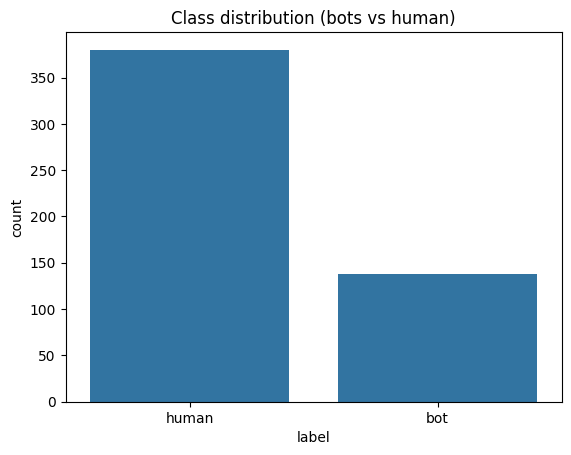

In [15]:
import matplotlib.pyplot as plt  
import seaborn as sns   

sns.countplot(x='label', data=df_full)
plt.title('Class distribution (bots vs human)')
plt.show()
    

There's an obvious unbalance. Later, we have to bear in mind this to develop the model.

Now, I will check outliers in important columns.

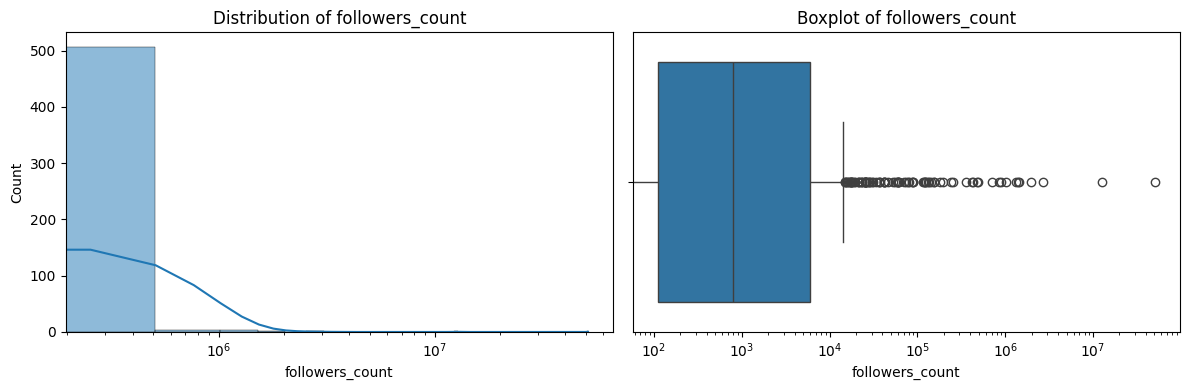

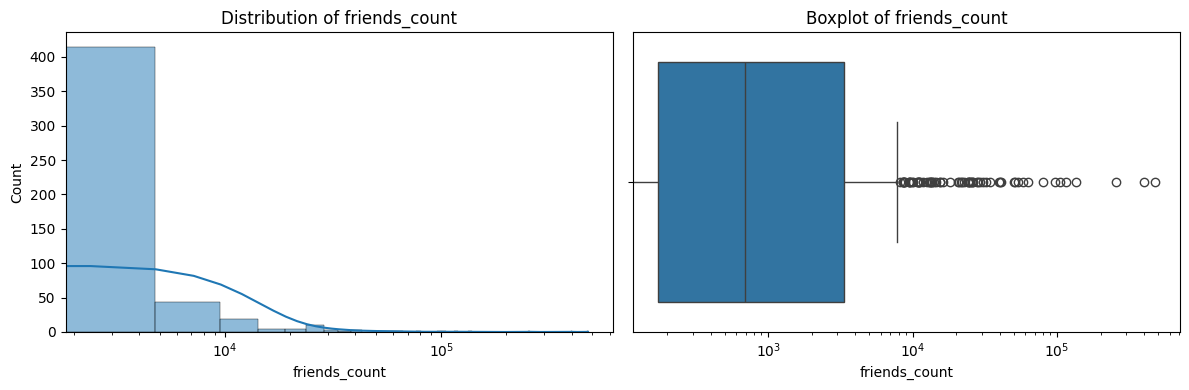

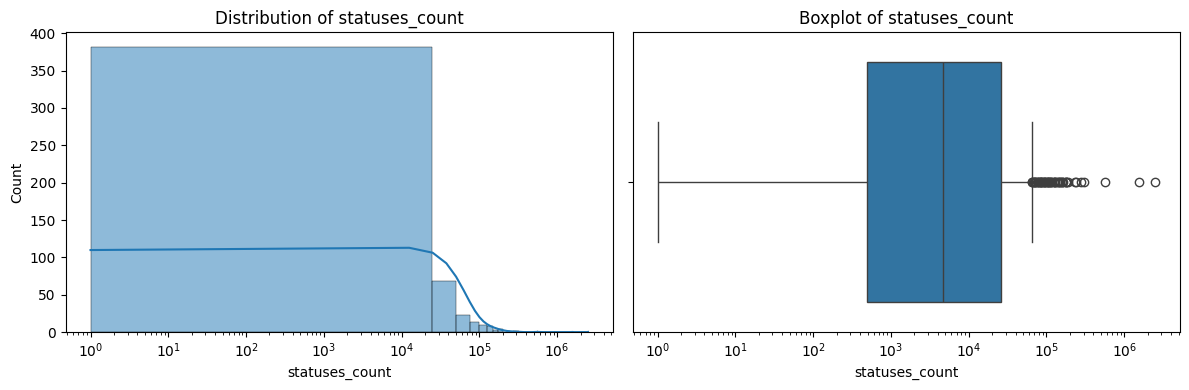

In [16]:
cols_to_plot = ['followers_count','friends_count','statuses_count']

for col in cols_to_plot:
    plt.figure(figsize=(12,4))
    # Hist
    plt.subplot(1,2,1)
    sns.histplot(df_full[col], bins=100, kde=True)
    plt.title(f'Distribution of {col}')
    plt.xscale('log')
    plt.xlabel(col)
    
    #Boxplot 
    plt.subplot(1,2,2)
    sns.boxplot(x=df_full[col])
    plt.xscale('log')
    plt.title(f'Boxplot of {col}')
    
    plt.tight_layout()
    plt.show()

There are some outliers. I will create some thresholds to filter the data.

In [17]:
# Setting up the threshold.
thresholds = {
    'friends_count' : df_full['friends_count'].quantile(0.99),
    'statuses_count' : df_full['statuses_count'].quantile(0.99),
    'followers_count' : df_full['followers_count'].quantile(0.99)
}
# Applying.
for col, th in thresholds.items():
    df_full[col] = df_full[col].clip(upper=th)


## Feature engineering

I'm creating some features to have a better vision of the behavior of every user.

In [18]:
import numpy as np
from datetime import datetime

# Starting with ratio of followers/friends.
df_full['followers_to_friends_ratio'] = df_full['followers_count'] / df_full['friends_count'] + 1

# Lifetime of the account.
# Deleting timezone.
if df_full['created_at'].dt.tz is not None:
    df_full["created_at"] = df_full["created_at"].dt.tz_convert(None)
today = datetime.now()
df_full['lifetime_account'] = (today - df_full['created_at']).dt.days

# Ratio of tweets per days.
df_full['tweets_per_day'] = df_full['statuses_count'] / (df_full['lifetime_account'] + 1)

# Complexity of the biography.
df_full["description_length"] = df_full["description"].astype(str).apply(len)

In [19]:
df_full[["user_id", "label", "followers_count", "friends_count",
         "followers_to_friends_ratio", 'lifetime_account',
         "tweets_per_day", "description_length"]].head()

,user_id,label,followers_count,friends_count,followers_to_friends_ratio,lifetime_account,tweets_per_day,description_length
0,2718436417,human,104.0,111.0,1.936937,3974,0.009560,41
1,792615528791703553,human,43.0,104.0,1.413462,3161,2.043643,0
2,3287012484,human,13146.0,4909.0,3.677938,3627,22.339581,106
3,93816184,human,2264.0,483.0,5.687371,5686,28.171092,97
4,754884880996020225,bot,5258.0,6228.0,1.844252,3265,31.790876,158


With the features created, let's analyse correlations.

In [ ]:
# Selecting numerical features.
num_cols_new = df_full.select_dtypes(include='number').columns
# features = num_cols_new.to_list
print(len(num_cols_new))
# Selecting concrete features.
features = [
    "friends_count",
    "followers_count",
    "statuses_count",
    "lifetime_account",
    "followers_to_friends_ratio",
    "tweets_per_day",
    "description_length",
]


12


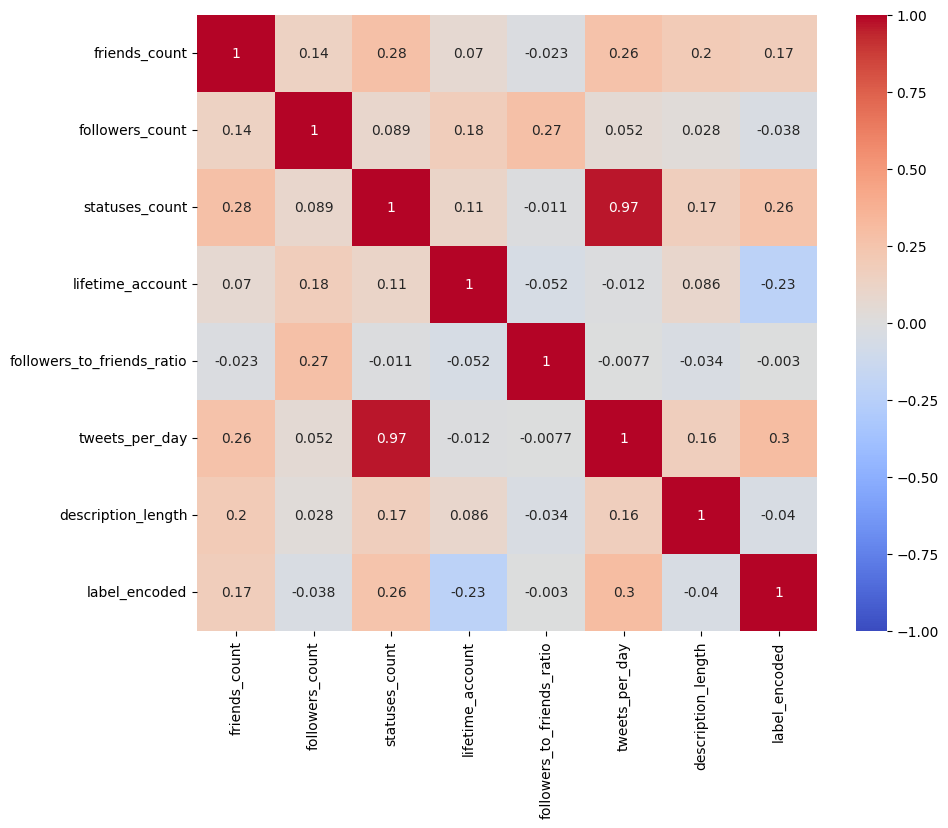

In [28]:
# Mapping the label variable to bool.
df_full['label_encoded'] = df_full['label'].map({'human':0, 'bot':1})
# Creating the correlation.
corr = df_full[features + ['label_encoded']].corr()
# Showing on a figure.
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.show()


The correlations don't show much.

## Model Training

First model will be a Random Forest to encounter as fast as possible a baseline.

I'll start by dividing the dataset on Training & Test.

In [29]:
from sklearn.model_selection import train_test_split

# X & Y.
X = df_full[features]
y = df_full['label_encoded']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, stratify=y, random_state=42)

In [31]:
# Infinite values.
X_train = X_train.replace([np.inf, -np.inf], np.nan)
X_test = X_test.replace([np.inf, -np.inf], np.nan)

# NaN values changed for 0.
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

Now, the model will be developed.

              precision    recall  f1-score   support

           0       0.86      0.95      0.90        76
           1       0.80      0.57      0.67        28

    accuracy                           0.85       104
   macro avg       0.83      0.76      0.78       104
weighted avg       0.84      0.85      0.84       104



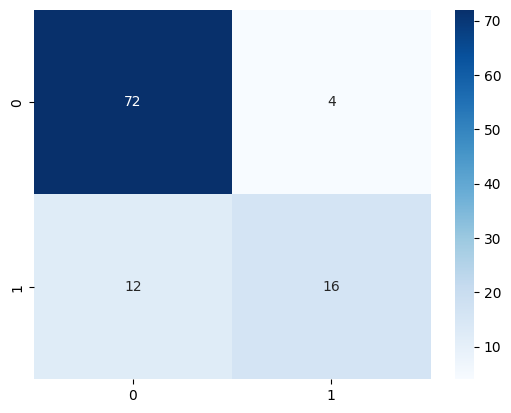

In [32]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Selecting the model.
model = RandomForestClassifier(random_state=42, class_weight='balanced')
model.fit(X_train, y_train)
# Predict.
y_pred = model.predict(X_test)
# Evaluation.
print(classification_report(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.show()

Very good results for a first model. Decent accuracy & precision.

I'll design an inferency funtion to insert data into the model to check how the model works.

In [33]:
def predict_user(model, user_data):
    # Temporal dataframe.
    df_user = pd.DataFrame([user_data])
    # Replace inf for NaN, after for 0.
    df_user = df_user.replace([np.inf, -np.inf], np.nan).fillna(0)
    # Predict.
    pred = model.predict(df_user)
    if pred[0] == 1:
        return 'The user inserted is a Bot.'
    else: 
        return 'The user inserted is a Human.'

In [36]:
user_data_example = {
    "friends_count": 150,
    "followers_count": 300,
    "statuses_count": 1000,
    "lifetime_account": 500,
    "followers_to_friends_ratio": 2.0,
    "tweets_per_day": 2.5,
    "description_length": 120
}

In [37]:
result = predict_user(model, user_data_example)
print(result)

The user inserted is a Human.


I'll do some other tries.

In [38]:
user_data_1 = {
    "friends_count": 10,
    "followers_count": 5,
    "statuses_count": 50,
    "lifetime_account": 100,
    "followers_to_friends_ratio": 0.5,
    "tweets_per_day": 0.5,
    "description_length": 30,
}
user_data_2 = {
    "friends_count": 2000,
    "followers_count": 5000,
    "statuses_count": 15000,
    "lifetime_account": 2500,
    "followers_to_friends_ratio": 2.5,
    "tweets_per_day": 6,
    "description_length": 100,
}
user_data_3 = {
    "friends_count": 500,
    "followers_count": 20,
    "statuses_count": 800,
    "lifetime_account": 300,
    "followers_to_friends_ratio": 0.04,
    "tweets_per_day": 2.66,
    "description_length": 15,
}

In [39]:
for idx, user_data in enumerate([user_data_1, user_data_2, user_data_3], 1):
    result = predict_user(model,user_data)
    print(result)

The user inserted is a Human.
The user inserted is a Human.
The user inserted is a Human.


Saving the model

In [40]:
import pickle

with open('model.pkl','wb') as f:
    pickle.dump(model, f)
print('Model saved succesfully!')

Model saved succesfully!
